# Домашнее задание 2: FM

Рекомендательные системы, Оксана Нырка

### Загрузка библиотек и данных

In [2]:
#!pip install xlearn-0.4.4-py2.py3-none-win_amd64.whl

Processing c:\users\оксана\documents\recsys\task_1_recsys\xlearn-0.4.4-py2.py3-none-win_amd64.whl
  Attempting uninstall: xlearn
    Found existing installation: xlearn 0.40a1
    Uninstalling xlearn-0.40a1:
      Successfully uninstalled xlearn-0.40a1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
import xlearn as xl
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

In [5]:
data = pd.read_csv('data.csv')
data = data.drop(columns = ['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])

In [6]:
# date_time : object -> datetime
data.date_time = pd.to_datetime(data.date_time)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1,1


### Описательный анализ

In [7]:
# Удалим выброс за 1 сентября
data = data[data['date_time'] >= pd.to_datetime('2021-09-26')]
print(data.shape)

(15821471, 9)


В этой задаче используем также *oaid_hash* - id юзера, посмотрим на нее:

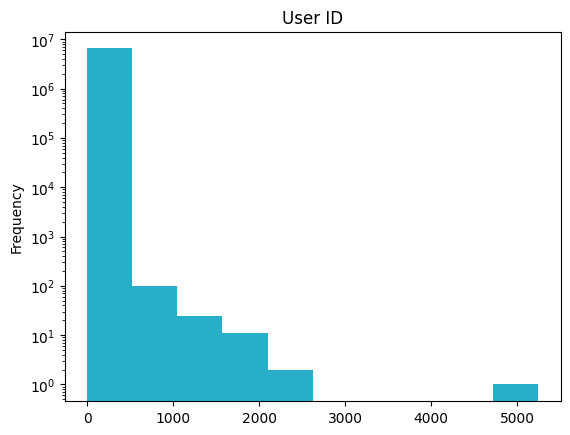

In [23]:
data.oaid_hash.value_counts().reset_index(drop = True).plot.hist(logy = True, color = "#27AFC9", title = 'User ID');

Заметим, что встречаются юзеры, на которых в датасете одно наблюдение, и их достаточно много, но они не несут много полезной информации. Т.к. удаление означает потерю большого количества данных, давайте их объединим в одну категорию.

Т.к. будем использовать матричные факторизации, помимо id юзера, добавим id баннера. Эту колонку никак видоизменять не будем.

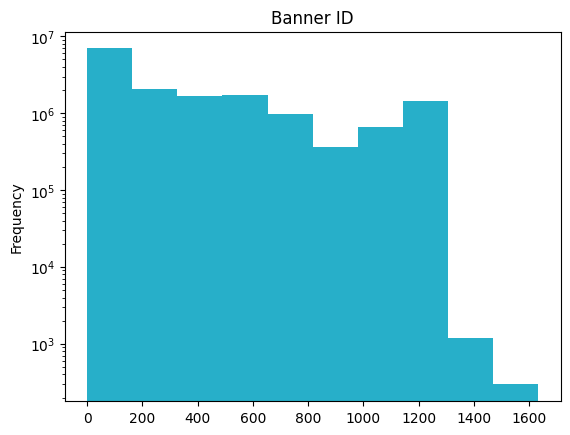

In [26]:
data.banner_id.plot.hist(logy = True, color = "#27AFC9", title = 'Banner ID');

### Feature engineering

Будем использовать те же фичи, что и в HW1 (с модификациями) + преобразуем *oaid_hash* и добавим *banner_id*.

> По-другому объединим *os_id*: редкие значения (от 7 до 10) в близкие значения по таргету

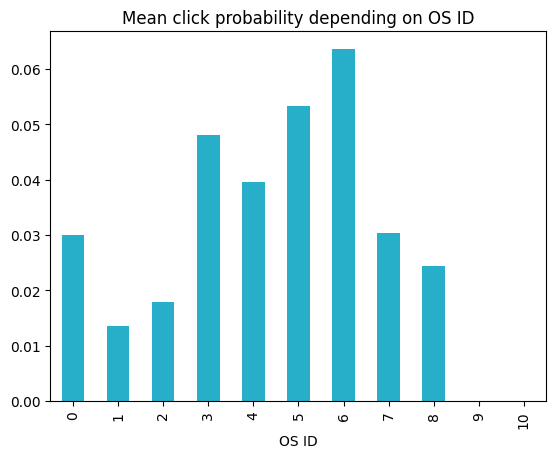

In [22]:
data.groupby('os_id')['clicks'].mean().plot.bar(title = "Mean click probability depending on OS ID", xlabel = "OS ID", color = "#27AFC9");

+ 9 и 10 категории добавим к первой
+ 7 к нулевой
+ 8 ко второй


> Разделим *campaign_clicks* другим способом (в HW1 использовалась бинарная фича: был клик до этого или нет)

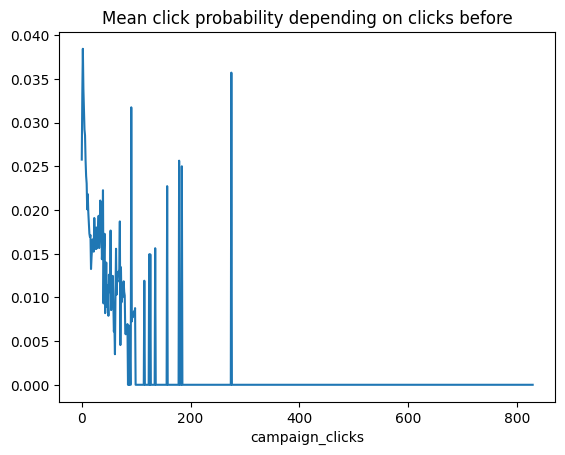

In [23]:
data.groupby('campaign_clicks')['clicks'].mean().plot(title = 'Mean click probability depending on clicks before');

*Наблюдение:* у часто показываемых реклам нет кликов (но там по одному наблюдению)

Сделаем бинарную переменную: меньше 200 кликов и больше

In [8]:
# в impressions все единицы - удалим колонку
data = data.drop('impressions', axis = 1)

# date_time
## достанем из date_time время суток и день недели
data['day'] = data['date_time'].dt.weekday
data['hour'] = data['date_time'].dt.hour

# zone_id
counts = data['zone_id'].value_counts()
idxs = counts[counts < 20].index
data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1

# os_id
data.os_id = data.os_id.replace({9: 1, 10: 1, 7: 2, 8: 2})

# campaign_clicks
data['before_clicks'] = data['campaign_clicks'] > 200
data['before_clicks'] = data['before_clicks'].astype('int64')

# oaid_hash
counts = data['oaid_hash'].value_counts()
idxs = counts[counts == 1].index
data.loc[data['oaid_hash'].isin(idxs), 'oaid_hash'] = -1

data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,day,hour,before_clicks
0,2021-09-27 00:01:30,0,0,-1,0,0,0,1,0,0,0
1,2021-09-26 22:54:49,1,1,-1,0,0,1,1,6,22,0
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,6,23,0
3,2021-09-27 00:04:30,3,3,-1,0,1,1,1,0,0,0
4,2021-09-27 00:06:21,4,4,-1,0,1,0,1,0,0,0


Разделим данные на трейн, валидацию и тест. В качестве теста возьмем последний день датасета, в качестве валидации - предпоследние полтора дня (выбрано так, чтобы размер был примерно как у теста).

In [9]:
x_train = data[data['date_time'] < pd.to_datetime('2021-10-02')]
x_val = x_train[~(x_train['date_time'] < pd.to_datetime('2021-09-30 12:00:00'))]
x_train = x_train[(x_train['date_time'] < pd.to_datetime('2021-09-30 12:00:00'))]
y_train, y_val = x_train['clicks'].values, x_val['clicks'].values
x_test = data[~(data['date_time'] < pd.to_datetime('2021-10-02'))]
y_test = x_test['clicks'].values
print('Train size:', len(x_train))
print('Validation size:', len(x_val))
print('Test size:', len(x_test))

Train size: 10986206
Validation size: 2706287
Test size: 2128978


In [26]:
# Удалим лишние колонки
x_train = x_train.drop(columns = ['campaign_clicks', 'date_time', 'clicks'])
x_val = x_val.drop(columns = ['campaign_clicks', 'date_time', 'clicks'])
x_test = x_test.drop(columns = ['campaign_clicks', 'date_time', 'clicks'])

In [27]:
# Получим one-hot encoded матрицу
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train = encoder.fit_transform(x_train)
X_val = encoder.transform(x_val)
X_test = encoder.transform(x_test)

Для того, чтобы использовать FFM из ***xlearn***, нужно привести данные к формату *libffm*:

label field_1:index_1:value_1 field_2:index_2:value_2 ...

In [29]:
# получим fields, чтобы удобно было доставать во время записи в файл
fields = []
for i, col in enumerate(x_train.columns):
    fields += [i]*len(x_train[col].unique())
fields = np.array(fields)

In [30]:
def to_libffm(data, labels, output_file):
    rows, indexes = data.nonzero()
    values = data.data
    with open(output_file, "w") as file:
        file.write(f"{labels[rows[0]]}")
        cur_row = rows[0]
        for row, index, value in zip(rows, indexes, values):
            # чтобы отделять наблюдения друг от друга
            if row == cur_row:
                file.write(f' {fields[index]}:{index}:{value}')
            else:
                file.write('\n')
                cur_row = row
                file.write(f'{labels[cur_row]}')
                file.write(f' {fields[index]}:{index}:{value}')

In [31]:
to_libffm(X_train, y_train, 'train.txt')
to_libffm(X_val, y_val, 'val.txt')
to_libffm(X_test, y_test, 'test.txt')

### Model: Field-aware Factorization Machine

**Baseline**: средний предикт по выборке

In [35]:
# baseline for validation
print("Validation baseline:")
pred = np.ones_like(y_val) * y_val.mean()
print(f"auc: {roc_auc_score(y_val, pred)}")
print(f"log_loss: {log_loss(y_val, pred)}")

Validation baseline:
auc: 0.5
log_loss: 0.16841889411733543


In [3]:
ffm_model = xl.create_ffm() 
ffm_model.setTrain("train.txt")

In [ ]:
ffm_model.setQuiet()

In [41]:
# default parameters for embedding size in xlearn library
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k': 4, 'epoch' : 10, 'opt' : 'adagrad'}
ffm_model.fit(param, "model_default.out")

In [14]:
# checking vaidation metrics for the default model: better than baseline
ffm_model.setSigmoid()
ffm_model.setTest("val.txt")
pred = ffm_model.predict("model_default.out")
print(f"auc: {roc_auc_score(y_val, pred)}")
print(f"log_loss: {log_loss(y_val, pred)}")

auc: 0.7661961820773829
log_loss: 0.15236212183309986


Теперь выберем размер эмбеддинга для модели и протестируем на валидационных данных.

Будем перебирать следующие значения: 2, 4, 8, 16 (размер больше не влезает в оперативку)

In [44]:
best_auc = 0.7661961820773829
best_loss = 0.15236212183309986
best_k = 4
for i, k in enumerate([2, 8, 16]):
    param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k': k, 'epoch' : 10, 'opt' : 'adagrad'}
    ffm_model.fit(param, "modelK"+str(k)+".out")
    ffm_model.setSigmoid()
    ffm_model.setTest("val.txt")
    pred = ffm_model.predict("modelK"+str(k)+".out")
    roc_auc = roc_auc_score(y_val, pred)
    logloss = log_loss(y_val, pred)
    print(f"roc-auc for k = {k}: {roc_auc}")
    print(f"log_loss for k = {k}: {logloss}")
    if roc_auc >= best_auc and logloss <= best_loss:
        best_auc = roc_auc
        best_loss = logloss
        best_k = k
print(f"Best embedding size = {best_k}")

roc-auc for k = 2: 0.7658041018767737
log_loss for k = 2: 0.15247663084644422
roc-auc for k = 8: 0.7661604965842023
log_loss for k = 8: 0.1526401433728459
roc-auc for k = 16: 0.7663236358406769
log_loss for k = 16: 0.15240009464246093
Best embedding size = 4


Попробуем поменять коэффициент регуляризации

In [45]:
best_auc = 0.7661961820773829
best_loss = 0.15236212183309986
best_lam = 0.002
for i, lam in enumerate([0.2 ,0.02, 0.0002, 0.00002]):
    param = {'task':'binary', 'lr':0.2, 'lambda':lam, 'k': 4, 'epoch' : 10, 'opt' : 'adagrad'}
    ffm_model.fit(param, "modelLam"+str(lam)+".out")
    ffm_model.setSigmoid()
    ffm_model.setTest("val.txt")
    pred = ffm_model.predict("modelLam"+str(lam)+".out")
    roc_auc = roc_auc_score(y_val, pred)
    logloss = log_loss(y_val, pred)
    print(f"roc-auc for lambda = {lam}: {roc_auc}")
    print(f"log_loss for lambda = {lam}: {logloss}")
    if roc_auc >= best_auc and logloss <= best_loss:
        best_auc = roc_auc
        best_loss = logloss
        best_lam = lam

roc-auc for lambda = 0.2: 0.7408369222192916
log_loss for lambda = 0.2: 0.17233973736745078
roc-auc for lambda = 0.02: 0.749043059015778
log_loss for lambda = 0.02: 0.16400143216163868
roc-auc for lambda = 0.0002: 0.7953045812045109
log_loss for lambda = 0.0002: 0.1448886662815498
roc-auc for lambda = 2e-05: 0.7793053054322663
log_loss for lambda = 2e-05: 0.15377652314924106


Наилучший коэффициент регуляризации: $\lambda = 0.0002$. Попробуем уменьшить и увеличить learning rate.

In [46]:
# при lr = 0.1: стало чуть хуже
param = {'task':'binary', 'lr':0.1, 'lambda': 0.0002, 'k': 4, 'epoch' : 30, 'opt' : 'adagrad'}
ffm_model.fit(param, "modelLR"+"_1"+".out")
ffm_model.setSigmoid()
ffm_model.setTest("val.txt")
pred = ffm_model.predict("modelLR"+"_1"+".out")
roc_auc = roc_auc_score(y_val, pred)
logloss = log_loss(y_val, pred)
print(f"roc-auc: {roc_auc}")
print(f"log_loss: {logloss}")

roc-auc: 0.7938316667911266
log_loss: 0.14585126933724027


In [10]:
# при lr = 0.3: стало хуже
param = {'task':'binary', 'lr':0.3, 'lambda': 0.0002, 'k': 4, 'epoch' : 30, 'opt' : 'adagrad'}
ffm_model.fit(param, "modelLR"+"_3"+".out")
ffm_model.setSigmoid()
ffm_model.setTest("val.txt")
pred = ffm_model.predict("modelLR"+"_3"+".out")
roc_auc = roc_auc_score(y_val, pred)
logloss = log_loss(y_val, pred)
print(f"roc-auc: {roc_auc}")
print(f"log_loss: {logloss}")

roc-auc: 0.7626494067073093
log_loss: 0.15997128122598675


**Финальная модель:** k = 4, lr = 0.2, lambda = 0.0002

### Оценка на тесте и сравнение с baseline

> в HW1 у меня был другой бейзлайн (всем предсказывать неклик), там log loss = 1.28, поэтому моя модель из HW1 его побила

Метрики HW1:

+ *log loss* = 0.59
+ *roc auc score* = 0.74

In [11]:
# checking test metrics for the chosen model
ffm_model.setSigmoid()
ffm_model.setTest("test.txt")
pred = ffm_model.predict("modelLR"+"_1"+".out")
print(f"test auc: {roc_auc_score(y_test, pred)}")
print(f"test log_loss: {log_loss(y_test, pred)}")

test auc: 0.7931429409991607
test log_loss: 0.1328144494195699


In [12]:
# test baseline
print("Test Baseline:")
pred = np.ones_like(y_test) * y_test.mean()
print(f"auc: {roc_auc_score(y_test, pred)}")
print(f"log_loss: {log_loss(y_test, pred)}")

Test Baseline:
auc: 0.5
log_loss: 0.15303289904918538


**Вывод:** получилось побить бейзлайн и результаты HW1 по обеим метрикам

+ log_loss(HW2) < log_loss(HW1)

+ roc_auc(HW2) > roc_auc(HW1)